In [92]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import QuantileTransformer

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('ravdess_features.csv')

In [5]:
df_copy = df.copy()

# Data Semantics
Introduce the variables with their meaning and characteristics

ravdess_features.csv è un file csv contenente un dataset originato da dei file audio in cui sono registrate delle brevi frasi pronunciate da 24 attori, 12 maschi e 12 femmine, e l'emozione con cui sono dette. Ogni record nel dataset rappresenta uno di questi audio, e ha come feature delle caratteristiche dell'audio.

Features:  
    **modality** (audio-only) -> *categorical*  
    **vocal_channel** (speech, song) -> *categorical*  
    **emotion** (neutral, calm, happy, sad, angry, fearful, disgust, surprised) -> *categorical*  
    **emotional_intensity** (normal, strong). NOTE: There is no strong intensity for the 'neutral' emotion -> *ordinal*  
    **statement** ("Kids are talking by the door", "Dogs are sitting by the door") *categorical*  
    **repetition** (1st repetition, 2nd repetition) -> *categorical*  
    **actor** (01 to 24) -> *categorical*  
    **sex** (M, F) -> *categorical*  
    **channels** (number of channels; 1 for mono, 2 for stereo audio) -> *categorical*  
    **sample_width** (number of bytes per sample; 1 means 8-bit, 2 means 16-bit) -> *categorical*  
    **frame_rate** (frequency of samples used (in Hertz)) -> *categorical*  
    **frame_width** (Number of bytes for each frame. One frame contains a sample for each channel.) -> *categorical*  
    **length_ms** (audio file length (in milliseconds)) -> *numeric*  
    **frame_count** (the number of frames from the sample) -> *numeric*  
    **intensity** (loudness in dBFS (dB relative to the maximum possible loudness)) -> *numeric*  
    **zero_crossings_sum** (sum of the zero-crossing rate, where The zero-crossing rate (ZCR) is the rate at which a signal changes from positive to zero to negative or from negative to zero to positive in a single frame) -> *numeric*  
    **'mean', 'std', 'min', 'max', 'kur', 'skew'** (statistics of the original audio signal. kur è la curtosi, che rappresenta un allontanamento dalla normalità distributiva, rispetto alla quale si verifica un maggiore appiattimento o un maggiore allungamento. skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean) -> *numeric*  
    **mfcc_ 'mean', 'std', 'min', 'max'** (statistics of the Mel-Frequency Cepstral Coefficients) -> *numeric*  
    ***Mel-Frequency Cepstral Coefficients*** (MFCCs) represent the spectral characteristics of an audio signal, specifically focusing on how humans perceive sound. They capture information about the frequency content of the signal, emphasizing frequencies that are more perceptually relevant (according to the Mel scale), and they represent this information in a compact form suitable for tasks like speech recognition, speaker identification, and audio classification. Essentially, MFCCs serve as a feature vector that summarizes the unique aspects of the audio signal's spectrum, making it easier for machine learning algorithms to process and analyze audio data.  
    **sc_ 'mean', 'std', 'min', 'max', 'kur', 'skew'** (statistics of the spectral centroid) -> *numeric*  
    ***The spectral centroid*** is a measure used in digital signal processing to characterise a spectrum. It indicates where the center of mass of the spectrum is located. Perceptually, it has a robust connection with the impression of brightness of a sound   
    **stft_ 'mean', 'std', 'min', 'max', 'kur', 'skew'** (statistics of the stft chromagram) -> *numeric*  
    ***STFT chromagram*** is a time-varying representation that provides insight into the harmonic content and chord progression of an audio signal representing the normalized distribution of energy in different pitch classes (or musical notes) over time

In [6]:
continuous_col = ['length_ms', 'frame_count', 'intensity', 'zero_crossings_sum', 'mean', 'std', 'min', 'max', 'kur', 
                      'skew', 'mfcc_mean', 'mfcc_std', 'mfcc_min', 'mfcc_max', 'sc_mean', 'sc_std', 'sc_min', 'sc_max', 
                      'sc_kur', 'sc_skew', 'stft_mean', 'stft_std', 'stft_min', 'stft_max', 'stft_kur', 'stft_skew']
discrete_col = ['modality', 'vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'actor', 
                    'sex', 'channels', 'sample_width', 'frame_rate', 'frame_width']

In [77]:
df.columns

Index(['modality', 'vocal_channel', 'emotion', 'emotional_intensity',
       'statement', 'repetition', 'actor', 'sex', 'channels', 'sample_width',
       'frame_rate', 'frame_width', 'length_ms', 'frame_count', 'intensity',
       'zero_crossings_sum', 'mfcc_mean', 'mfcc_std', 'mfcc_min', 'mfcc_max',
       'sc_mean', 'sc_std', 'sc_min', 'sc_max', 'sc_kur', 'sc_skew',
       'stft_mean', 'stft_std', 'stft_min', 'stft_max', 'stft_kur',
       'stft_skew', 'mean', 'std', 'min', 'max', 'kur', 'skew'],
      dtype='object')

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   modality             2452 non-null   object 
 1   vocal_channel        2256 non-null   object 
 2   emotion              2452 non-null   object 
 3   emotional_intensity  2452 non-null   object 
 4   statement            2452 non-null   object 
 5   repetition           2452 non-null   object 
 6   actor                1326 non-null   float64
 7   sex                  2452 non-null   object 
 8   channels             2452 non-null   int64  
 9   sample_width         2452 non-null   int64  
 10  frame_rate           2452 non-null   int64  
 11  frame_width          2452 non-null   int64  
 12  length_ms            2452 non-null   int64  
 13  frame_count          2452 non-null   float64
 14  intensity            1636 non-null   float64
 15  zero_crossings_sum   2452 non-null   i

Notiamo subito che le variabili vocal_channel, intensity e actor contengono missing values.

In [79]:
df.nunique()

modality                  1
vocal_channel             2
emotion                   8
emotional_intensity       2
statement                 2
repetition                2
actor                    24
sex                       2
channels                  2
sample_width              1
frame_rate                1
frame_width               2
length_ms                95
frame_count             158
intensity               989
zero_crossings_sum     2176
mfcc_mean              2451
mfcc_std               2449
mfcc_min               2451
mfcc_max               2449
sc_mean                2451
sc_std                 2451
sc_min                 1431
sc_max                 2423
sc_kur                 2451
sc_skew                2451
stft_mean              2451
stft_std               2451
stft_min               1431
stft_max                  1
stft_kur               2451
stft_skew              2451
mean                   2450
std                    2451
min                    2148
max                 

Numero di valori distinti per variabile

Le variabili modality, sample_width, frame_rate e stft_max si potranno eliminare perché sono costanti.

In [80]:
df.head()

modality vocal_channel    emotion emotional_intensity  \
0  audio-only        speech    fearful              normal   
1  audio-only        speech      angry              normal   
2  audio-only           NaN      happy              strong   
3  audio-only           NaN  surprised              normal   
4  audio-only          song      happy              strong   

                      statement repetition  actor sex  channels  sample_width  \
0  Dogs are sitting by the door        2nd    2.0   F         1             2   
1  Dogs are sitting by the door        1st   16.0   F         1             2   
2  Dogs are sitting by the door        2nd   16.0   F         1             2   
3  Kids are talking by the door        1st   14.0   F         1             2   
4  Dogs are sitting by the door        2nd    2.0   F         1             2   

   frame_rate  frame_width  length_ms  frame_count  intensity  \
0       48000            2       3737     179379.0     -36.79   
1       48000            2       3904     187387.0        NaN   
2       48000            2       4671     224224.0     -32.29   
3       48000            2       3637     174575.0     -49.02   
4       48000            2       4404     211411.0     -31.21   

   zero_crossings_sum  mfcc_mean  mfcc_std  mfcc_min  mfcc_max  sc_mean  \
0               16995     -33.49    134.65   -755.22    171.69  5792.55   
1               13906     -29.50    130.49   -713.99    205.01  5197.62   
2               18723     -30.53    126.58   -726.06    165.46  4830.74   
3               11617     -36.06    159.73   -842.95    190.04  5376.45   
4               15137     -31.41    122.13   -700.70    161.13  5146.01   

    sc_std  sc_min    sc_max  sc_kur  sc_skew  stft_mean  stft_std  stft_min  \
0  3328.06     0.0  13541.96   -1.12     0.25       0.42      0.34       0.0   
1  4040.93     0.0  12000.29   -1.53     0.22       0.42      0.35       0.0   
2  3332.13     0.0  12007.75   -1.13     0.44       0.38      0.35       0.0   
3  4053.66     0.0  12048.22   -1.50     0.10       0.41      0.36       0.0   
4  3442.72     0.0  12025.58   -1.17     0.50       0.42      0.35       0.0   

   stft_max  stft_kur  stft_skew      mean       std   min   max    kur  skew  
0       1.0     -1.22       0.40  3.84e-07  1.45e-02 -0.13  0.14   9.41  0.27  
1       1.0     -1.38       0.29 -7.15e-08  2.04e-02 -0.31  0.26  19.56  0.29  
2       1.0     -1.24       0.47  2.43e-06  2.43e-02 -0.14  0.17   4.88  0.30  
3       1.0     -1.45       0.27  2.37e-07  3.56e-03 -0.03  0.02  13.04 -0.08  
4       1.0     -1.37       0.32  8.45e-07  2.75e-02 -0.19  0.24   7.49  0.41

# Distribution of the variables and statistics
Explore (single, pairs of…) variables quantitatively (e.g., statistics, distributions)

In [82]:
pd.set_option('display.precision',2)
df.describe(include="all")

modality vocal_channel  emotion emotional_intensity  \
count         2452          2256     2452                2452   
unique           1             2        8                   2   
top     audio-only        speech  fearful              normal   
freq          2452          1335      376                1320   
mean           NaN           NaN      NaN                 NaN   
std            NaN           NaN      NaN                 NaN   
min            NaN           NaN      NaN                 NaN   
25%            NaN           NaN      NaN                 NaN   
50%            NaN           NaN      NaN                 NaN   
75%            NaN           NaN      NaN                 NaN   
max            NaN           NaN      NaN                 NaN   

                           statement repetition    actor   sex  channels  \
count                           2452       2452  1326.00  2452   2452.00   
unique                             2          2      NaN     2       NaN   
top     Dogs are sitting by the door        2nd      NaN     M       NaN   
freq                            1226       1226      NaN  1248       NaN   
mean                             NaN        NaN    12.58   NaN      1.00   
std                              NaN        NaN     6.92   NaN      0.05   
min                              NaN        NaN     1.00   NaN      1.00   
25%                              NaN        NaN     7.00   NaN      1.00   
50%                              NaN        NaN    13.00   NaN      1.00   
75%                              NaN        NaN    19.00   NaN      1.00   
max                              NaN        NaN    24.00   NaN      2.00   

        sample_width  frame_rate  frame_width  length_ms  frame_count  \
count         2452.0      2452.0       2452.0    2452.00      2452.00   
unique           NaN         NaN          NaN        NaN          NaN   
top              NaN         NaN          NaN        NaN          NaN   
freq             NaN         NaN          NaN        NaN          NaN   
mean             2.0     48000.0          2.0    4092.15    193587.19   
std              0.0         0.0          0.1     598.32     36825.37   
min              2.0     48000.0          2.0    2936.00        -1.00   
25%              2.0     48000.0          2.0    3604.00    172972.00   
50%              2.0     48000.0          2.0    4004.00    190591.00   
75%              2.0     48000.0          2.0    4538.00    217817.00   
max              2.0     48000.0          4.0    6373.00    305906.00   

        intensity  zero_crossings_sum  mfcc_mean  mfcc_std  mfcc_min  \
count     1636.00             2452.00    2452.00   2452.00   2452.00   
unique        NaN                 NaN        NaN       NaN       NaN   
top           NaN                 NaN        NaN       NaN       NaN   
freq          NaN                 NaN        NaN       NaN       NaN   
mean       -37.63            12885.31     -28.77    136.78   -758.91   
std          8.45             3665.32       4.46     20.45     99.95   
min        -63.86             4721.00     -43.81     83.62  -1085.48   
25%        -43.54            10362.50     -31.83    122.62   -826.46   
50%        -37.07            12383.50     -28.68    136.52   -760.98   
75%        -31.59            14966.00     -25.55    151.39   -692.89   
max        -16.35            30153.00     -15.49    195.94   -461.49   

        mfcc_max  sc_mean   sc_std   sc_min    sc_max   sc_kur  sc_skew  \
count    2452.00  2452.00  2452.00  2452.00   2452.00  2452.00  2452.00   
unique       NaN      NaN      NaN      NaN       NaN      NaN      NaN   
top          NaN      NaN      NaN      NaN       NaN      NaN      NaN   
freq         NaN      NaN      NaN      NaN       NaN      NaN      NaN   
mean      199.18  5170.10  3365.45   551.83  11830.46    -1.14     0.35   
std        26.00   875.19   580.48   508.03   1004.96     0.57     0.35   
min       126.25  2360.88  1491.34     0.00   765

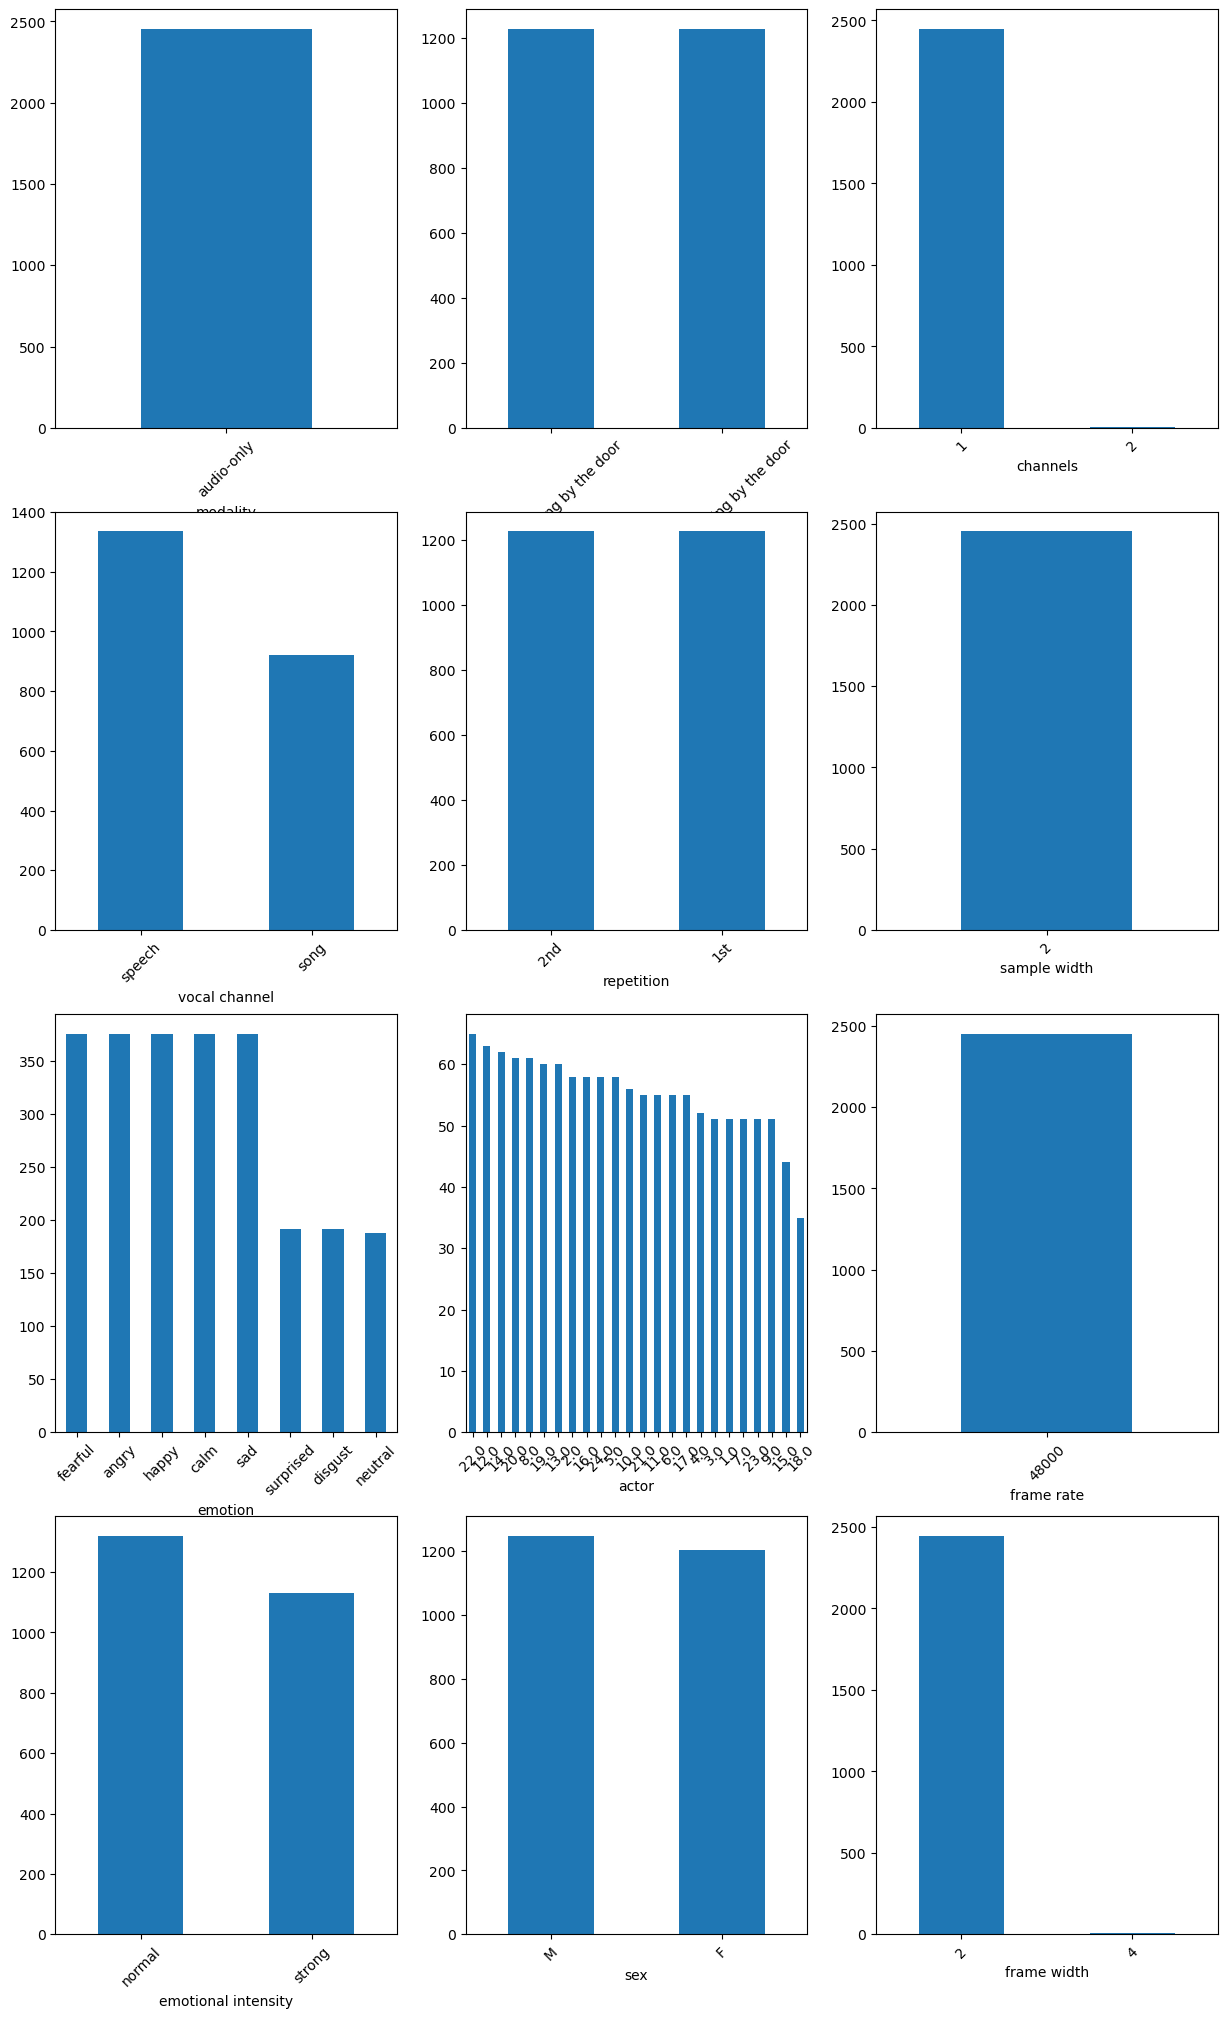

In [7]:
fig = plt.figure(figsize=(15, 25)) 
fig_dims = (4, 3)

cols = discrete_col
i = 0
for col in cols:
    plt.subplot2grid(fig_dims, (i%4, i//4))
    df[col].value_counts().plot(kind='bar')
    plt.xticks(rotation=45)
    plt.xlabel(col.replace('_', ' '))
    i = i+1

plt.show()

In [47]:
all(df[df['channels'] == 2].index == df[df['frame_width'] == 4].index)

True

quindi frame width = 2*channels

In [12]:
df['channels'].value_counts()

channels
1    2446
2       6
Name: count, dtype: int64

Notiamo che le variabili channels e frame width sono estremamente sbilanciate. Essendo quasi costanti le potremo eliminare.
Decidiamo di eliminare anche la variabile actor perché oltre ad essere per quasi la metà missing, non contiene informazioni utili per la nostra analisi, che avrà come obbiettivo della parte di classificazione la predizione della variabile emotion.

In [50]:
discrete_col_to_delete = ['modality', 'channels', 'sample_width', 'actor', 'frame_rate', 'frame_width']

In [51]:
discrete_col_to_keep = [col for col in discrete_col if col not in discrete_col_to_delete]

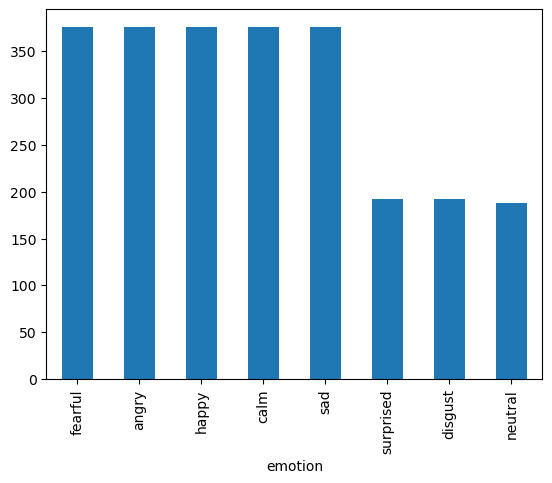

In [84]:
df['emotion'].value_counts().plot(kind='bar')
plt.show()

Le frequenze minori di surprised, disgust e neutral si spiegano perché i primi due sono valori ammissibili dell'attributo emotion quando il valore di vocal channel è speech, l'ultimo quando il valore di emotional intensity è normal.

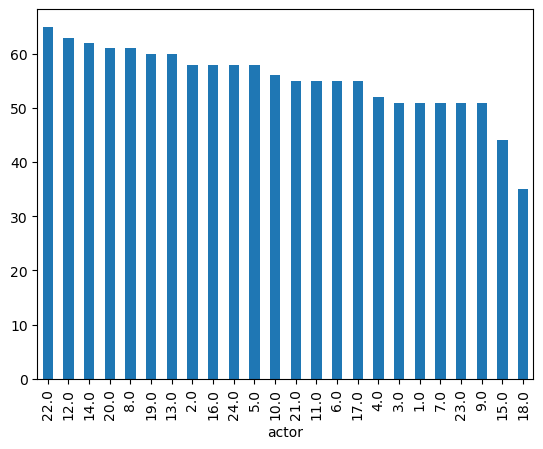

In [85]:
df['actor'].value_counts().plot(kind='bar')
plt.show()

Questo grafico in realtà non è molto significativo perché solo approssimativamente la metà dei valori di actor è non nullo.

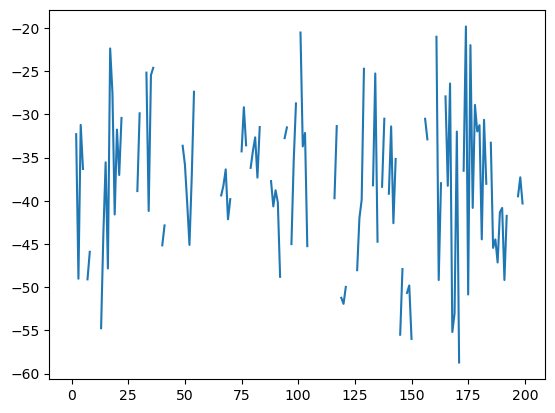

In [89]:
df['intensity'].iloc[0:200].plot()
plt.show()

In questo grafico si vede come l'attributo intensity abbia molti missing values.

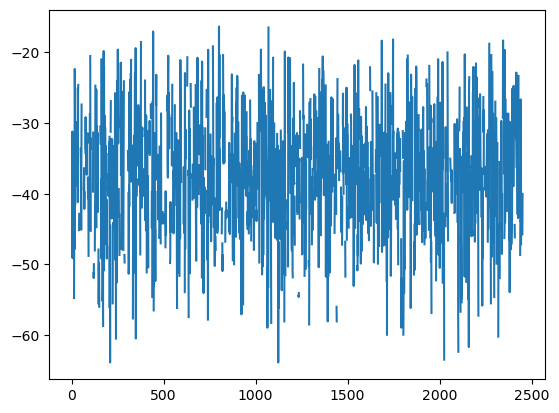

In [90]:
df['intensity'].plot()
plt.show()

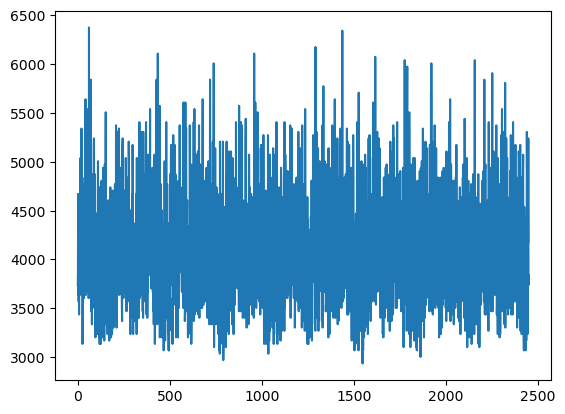

In [91]:
df['length_ms'].plot()
plt.show()

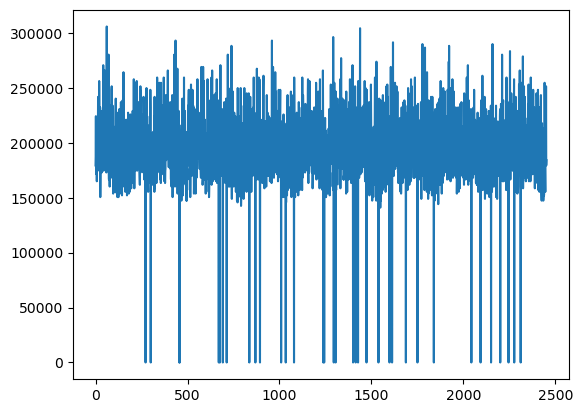

In [92]:
df['frame_count'].plot()
plt.show()

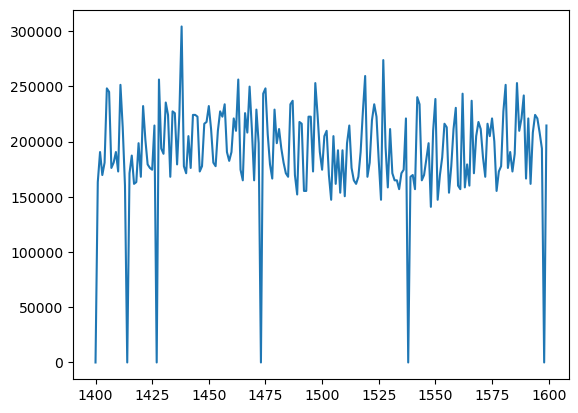

In [93]:
df['frame_count'].iloc[1400:1600].plot()
plt.show()

Da questi grafici si vedono possibili valori anomali dove frame count vale 0.
Notiamo tuttavia che frame_count dovrebbe essere legato a length_ms e frame_rate dalla relazione length_ms = frame_count/frame_rate*1000.

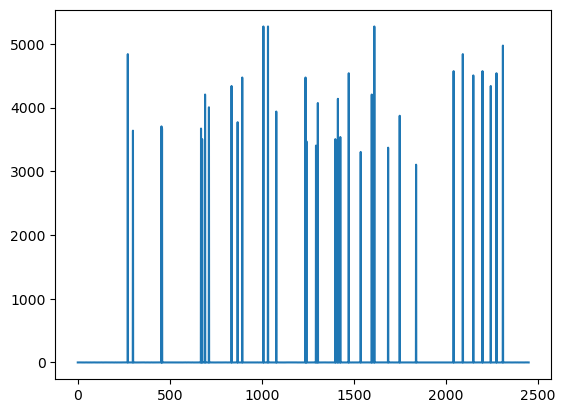

In [12]:
length_diff = df['length_ms']-df['frame_count']/df['frame_rate']*1000
length_diff.plot()
plt.show()

Verifico che queste deviazioni corrispondano a quelle in frame_count

In [13]:
((length_diff > 1) == (df['frame_count'] < 1)).all()

True

Dunque potremo considerare al posto delle tre variabili length_ms, frame_count, frame_rate, solo la variabile length_ms (in questo modo risolviamo anche il problema dei valori anomali di frame_count).

In [15]:
continuous_col_to_delete = ['stft_max', 'frame_count']
continuous_col_to_keep = [col for col in continuous_col if col not in continuous_col_to_delete]

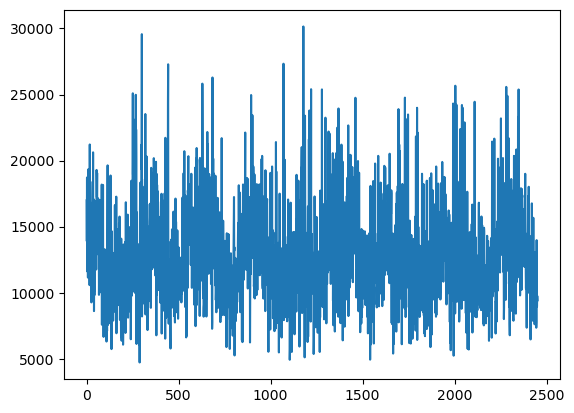

In [96]:
df['zero_crossings_sum'].plot()
plt.show()

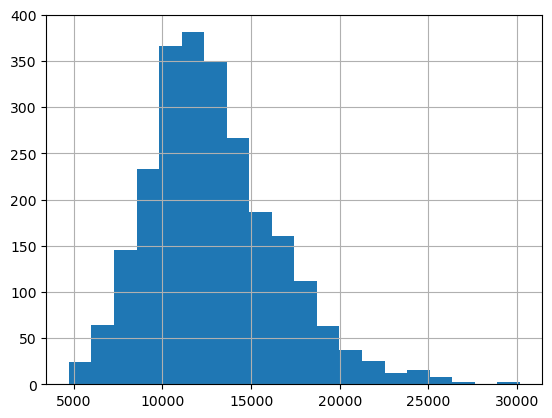

In [97]:
df['zero_crossings_sum'].hist(bins=20)
plt.show()

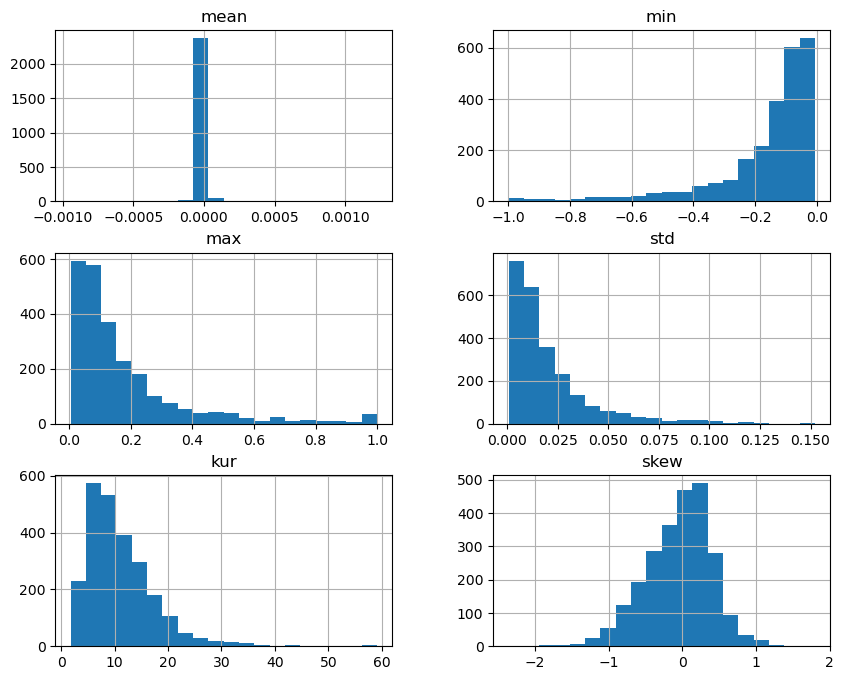

In [98]:
df[['mean','min','max','std','kur','skew']].hist(figsize=(10, 8), bins=20)
plt.show()

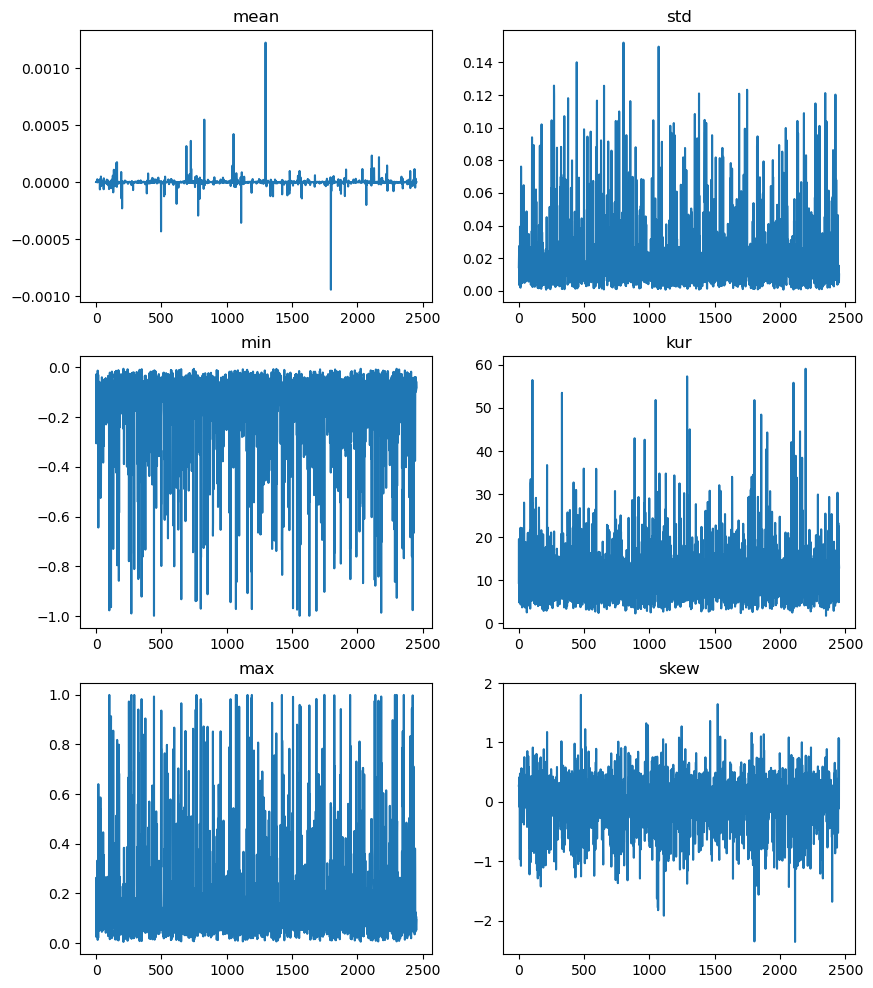

In [99]:
fig = plt.figure(figsize=(10, 12)) 
fig_dims = (3, 2)

cols = ['mean','min','max','std','kur','skew']
i = 0
for col in cols:
    if i <= 2:
        plt.subplot2grid(fig_dims, (i, 0))
    else:
        plt.subplot2grid(fig_dims, (i-3, 1))
    df[col].plot()
    #plt.xticks(rotation=45)
    plt.title(col.replace('_', ' '))
    i = i+1

plt.show()
plt.show()

Da questi grafici e istogrammi osserviamo che la variabile mean è schiacciata sullo zero e con molti outliers. 

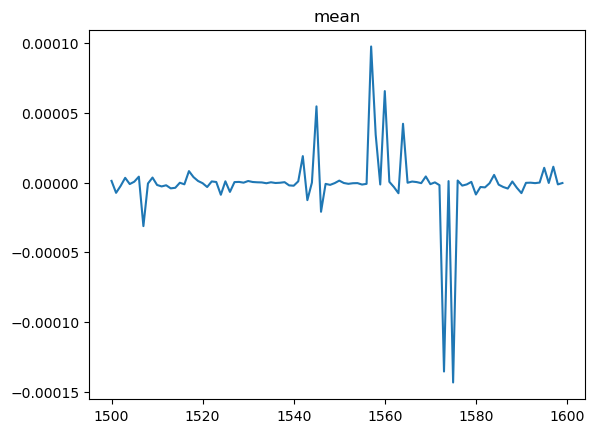

In [101]:
df['mean'][1500:1600].plot()
plt.title('mean')
plt.show()

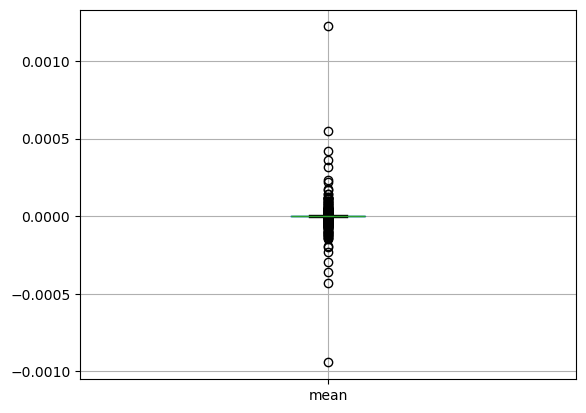

In [102]:
df.boxplot(column='mean')
plt.show()

Il boxplot conferma le nostre osservazioni sul grafico e l'istogramma di mean.

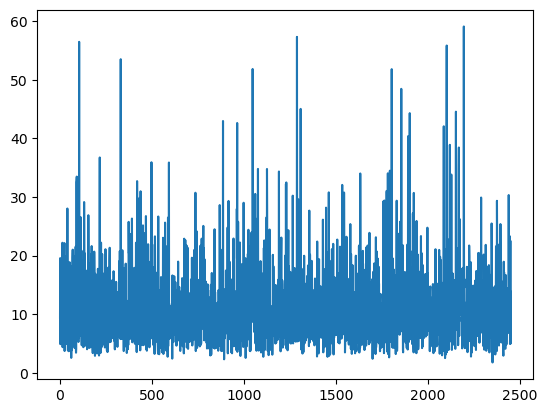

In [104]:
df['kur'].plot()
plt.show()

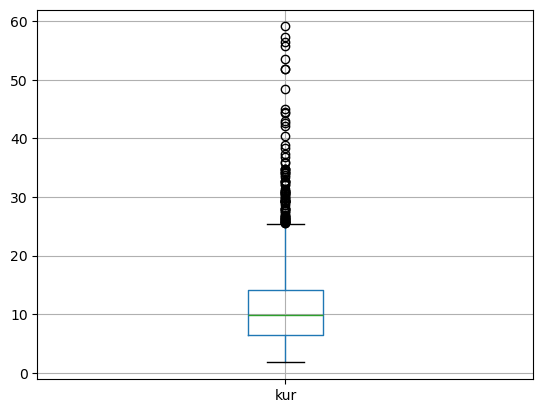

In [105]:
df.boxplot(column='kur')
plt.show()

Osserviamo che kur presenta molti outliers, ma non sembrano essere dovuti a errori nella raccolata dei dati e sembrano coerenti con i valori che assume la variabile.

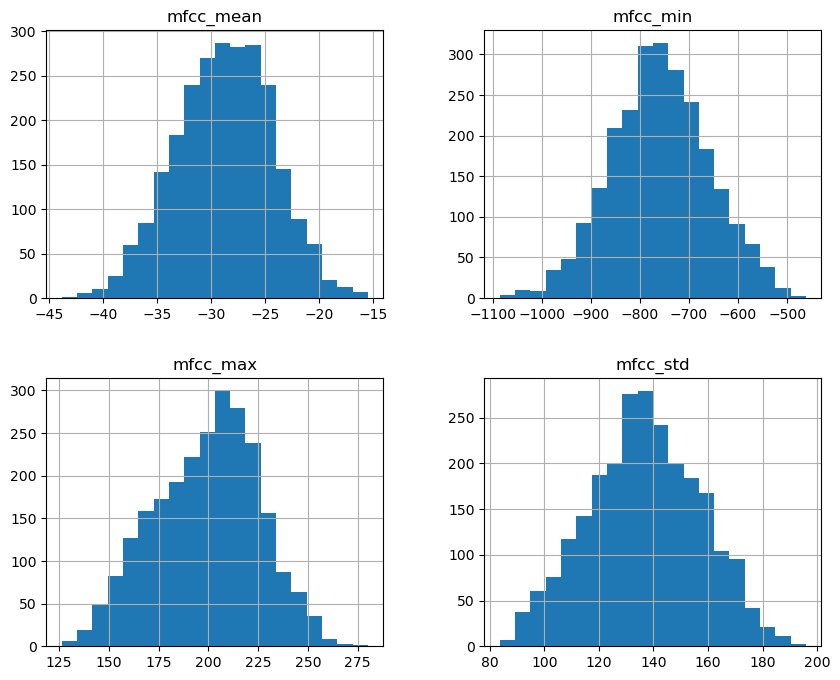

In [106]:
df[['mfcc_mean','mfcc_min','mfcc_max','mfcc_std']].hist(figsize=(10, 8), bins=20)
plt.show()

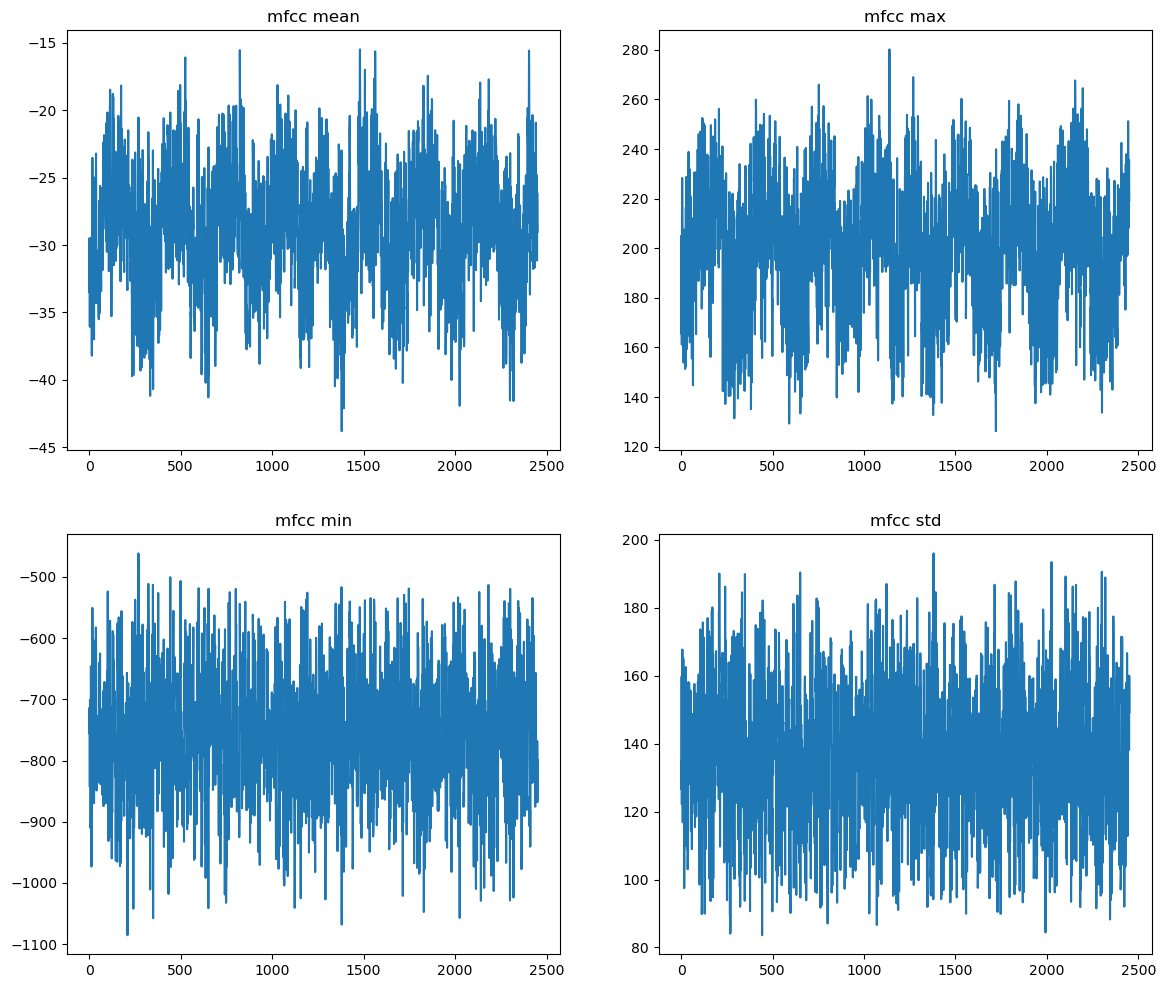

In [107]:
fig = plt.figure(figsize=(14, 12)) 
fig_dims = (2, 2)

cols = ['mfcc_mean','mfcc_min','mfcc_max','mfcc_std']
i = 0
for col in cols:
    if i <= 1:
        plt.subplot2grid(fig_dims, (i, 0))
    else:
        plt.subplot2grid(fig_dims, (i-2, 1))
    df[col].plot()
    #plt.xticks(rotation=45)
    plt.title(col.replace('_', ' '))
    i = i+1

plt.show()
plt.show()

Le variabili mfcc hanno distribuzioni vicine a quella normale e non sembrano presentare particolari problemi.

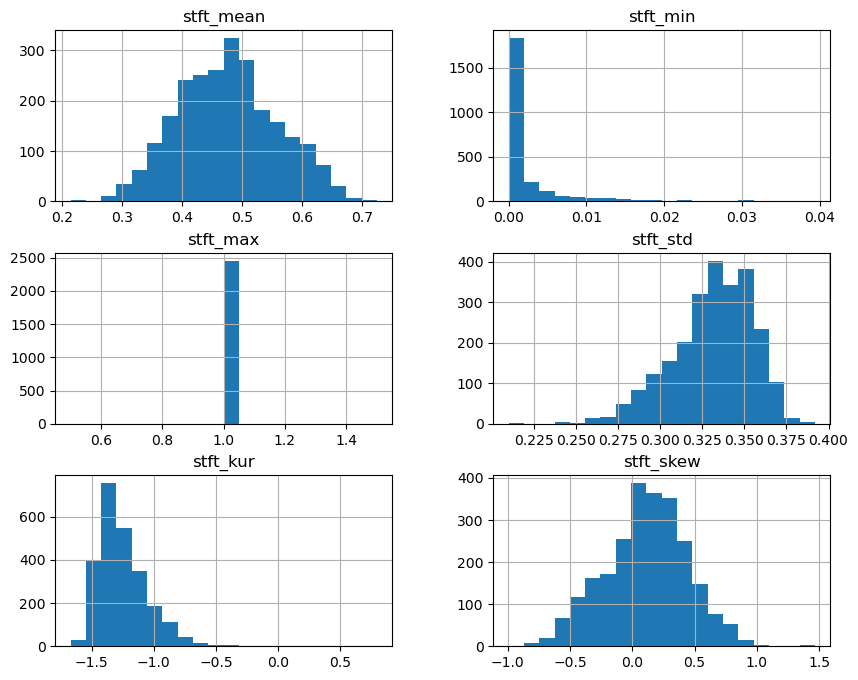

In [108]:
df[['stft_mean','stft_min','stft_max','stft_std','stft_kur','stft_skew']].hist(figsize=(10, 8), bins=20)
plt.show()

In [22]:
(df['stft_min'] == 0).sum()

1021

Interpretiamo i valori 0 di stft_min come degli errori di misurazione e li tratteremo quindi come missing values.

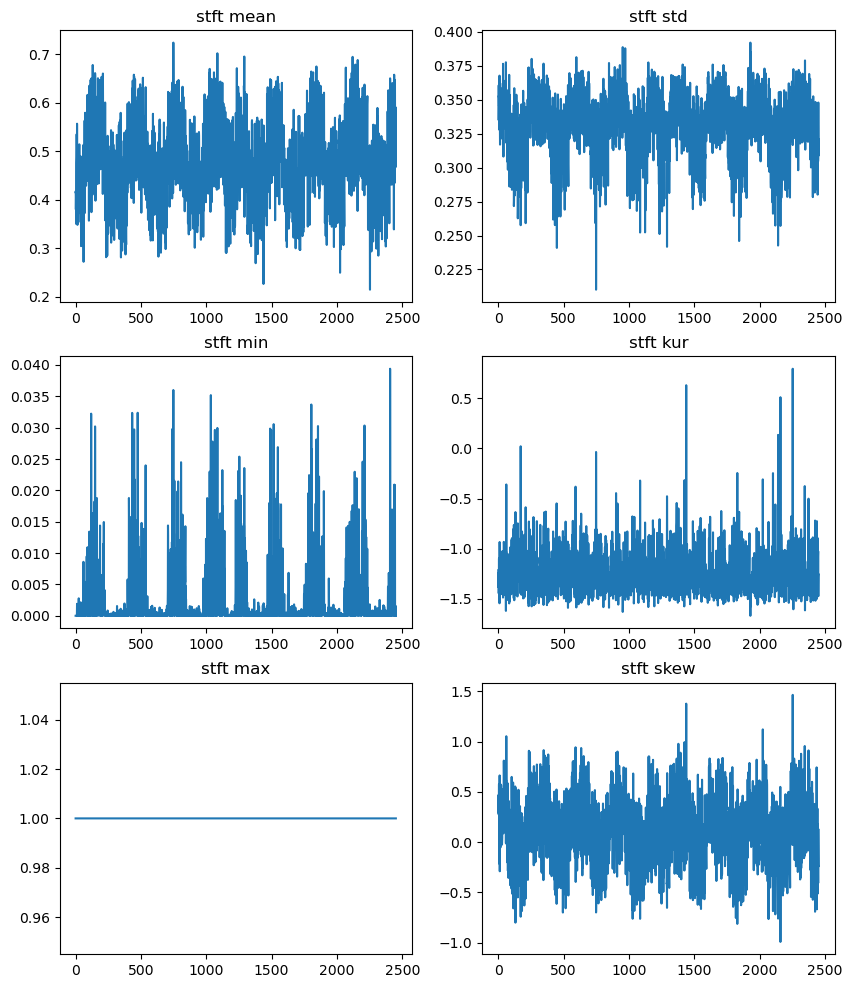

In [109]:
fig = plt.figure(figsize=(10, 12)) 
fig_dims = (3, 2)

cols = ['stft_mean','stft_min','stft_max','stft_std','stft_kur','stft_skew']
i = 0
for col in cols:
    if i <= 2:
        plt.subplot2grid(fig_dims, (i, 0))
    else:
        plt.subplot2grid(fig_dims, (i-3, 1))
    df[col].plot()
    #plt.xticks(rotation=45)
    plt.title(col.replace('_', ' '))
    i = i+1

plt.show()
plt.show()

Queste variabi sembrano evidenziare un pattern periodico.

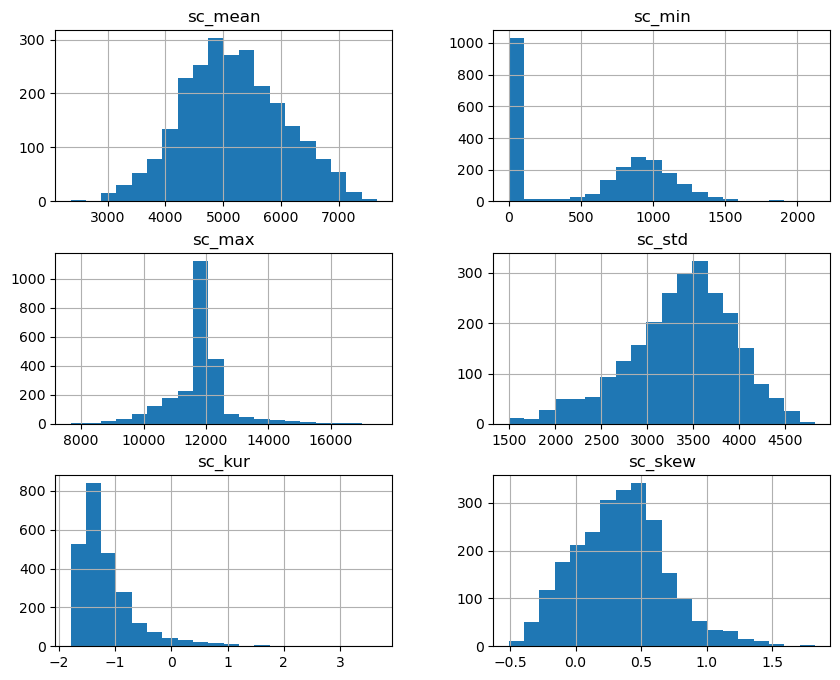

In [23]:
df[['sc_mean','sc_min','sc_max','sc_std','sc_kur','sc_skew']].hist(figsize=(10, 8), bins=20)
plt.show()

In [24]:
(df['sc_min'] == 0).sum()

1021

Interpretiamo i valori 0 di sc_min come degli errori di misurazione e li tratteremo quindi come missing values.

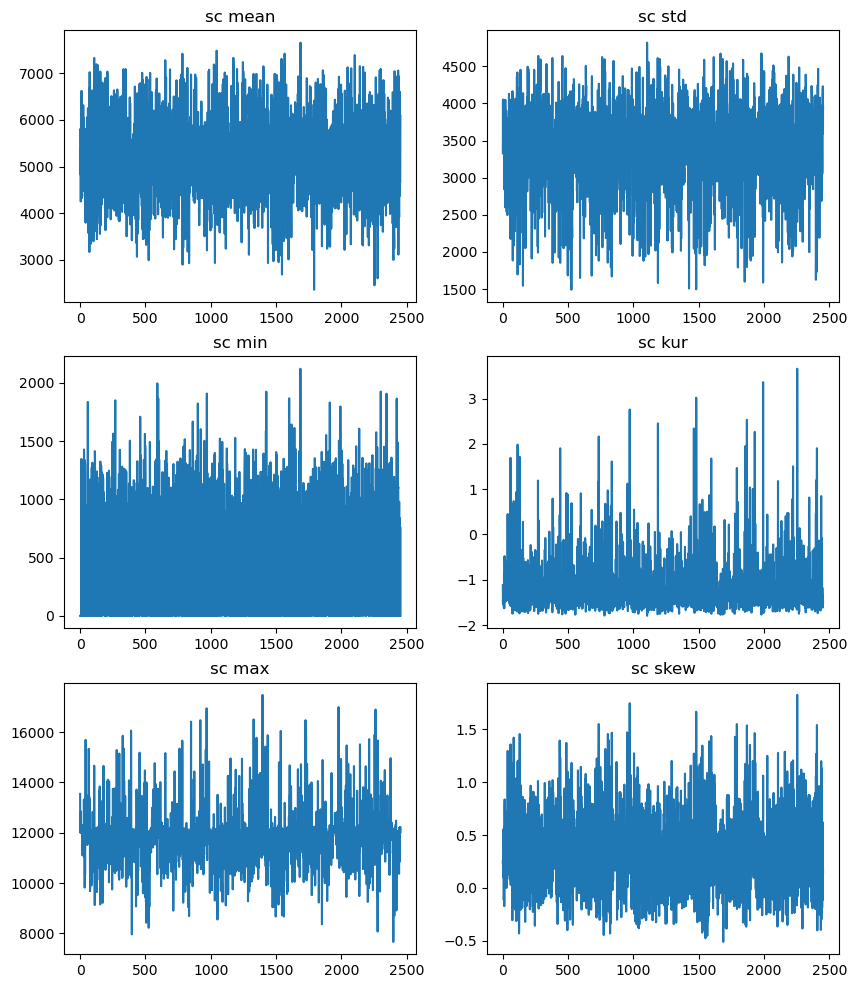

In [111]:
fig = plt.figure(figsize=(10, 12)) 
fig_dims = (3, 2)

cols = ['sc_mean','sc_min','sc_max','sc_std','sc_kur','sc_skew']
i = 0
for col in cols:
    if i <= 2:
        plt.subplot2grid(fig_dims, (i, 0))
    else:
        plt.subplot2grid(fig_dims, (i-3, 1))
    df[col].plot()
    #plt.xticks(rotation=45)
    plt.title(col.replace('_', ' '))
    i = i+1

plt.show()
plt.show()

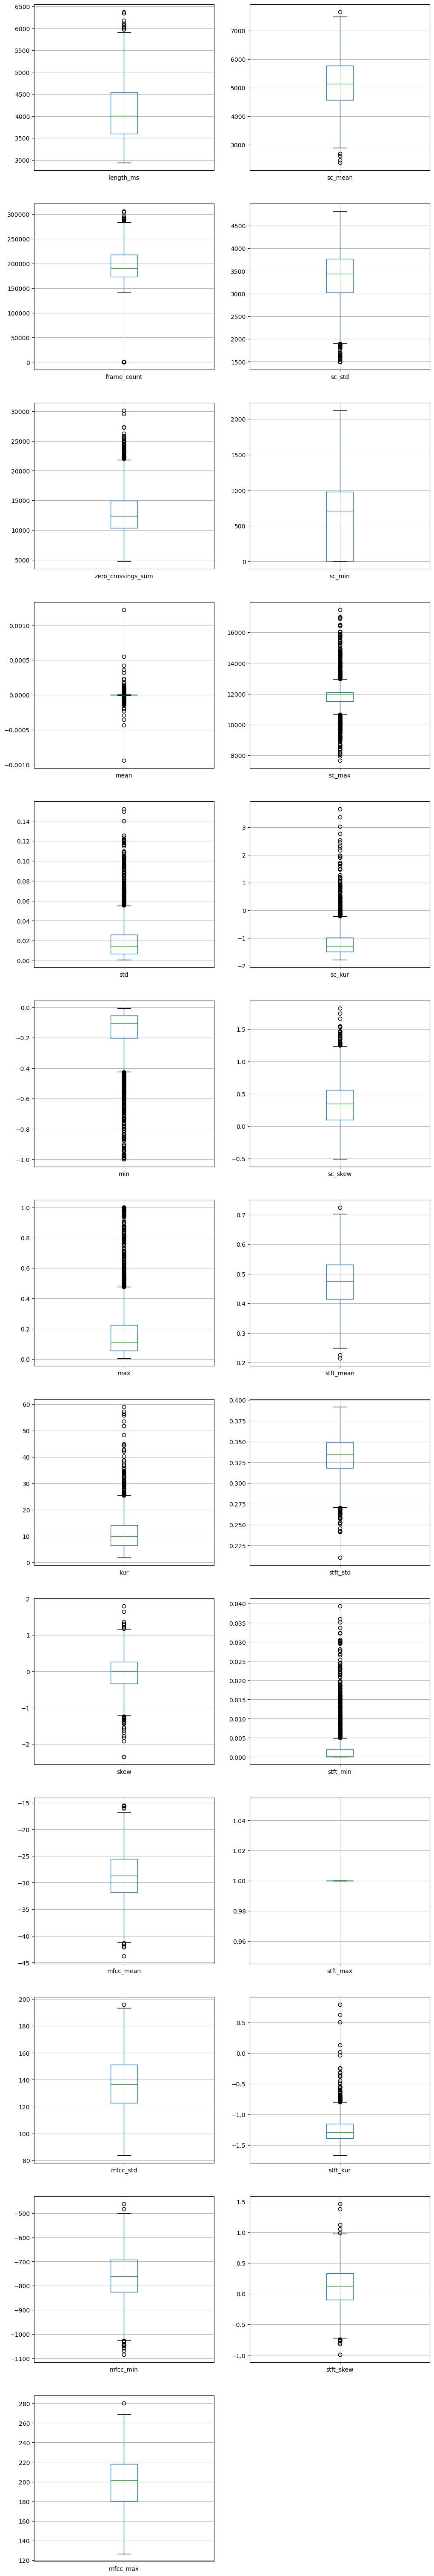

In [26]:
# in cols ho escluso intensity perchè la funzione boxplot non vuole missing values

fig = plt.figure(figsize=(12, 78)) 
fig_dims = (13, 2)
cols = [col for col in continuous_col if col != 'intensity']
i = 0
for col in cols:
    if i <= 12:
        plt.subplot2grid(fig_dims, (i, 0))
    else:
        plt.subplot2grid(fig_dims, (i-13, 1))
    df.boxplot(column=col)
    #plt.xticks(rotation=45)
    i = i+1

plt.show()
plt.show()

In generale osserviamo che le variabili presentano molto outliers, ma che nella maggior parte dei casi questi sembrano essere coerenti con i valori che la variabile assume.
Nel boxplot di sc_min i valori anomali 0 non vengono visualizzati come outliers perché sono più del 10% e quindi il whisker ha lunghezza zero.
Infine come ci aspettavamo nel boxplot di framecount vediamo degli outliers in corrispondenza dello 0.

# Scatter

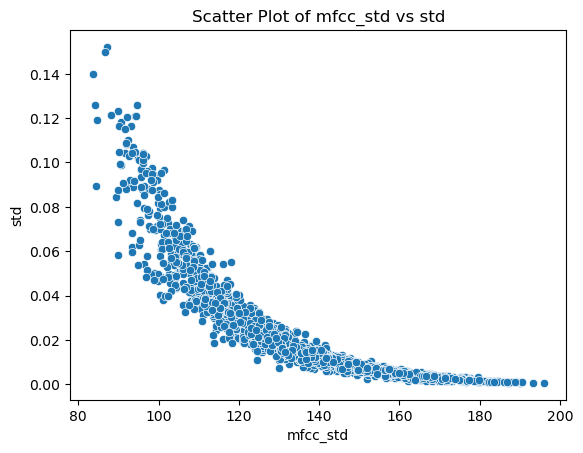

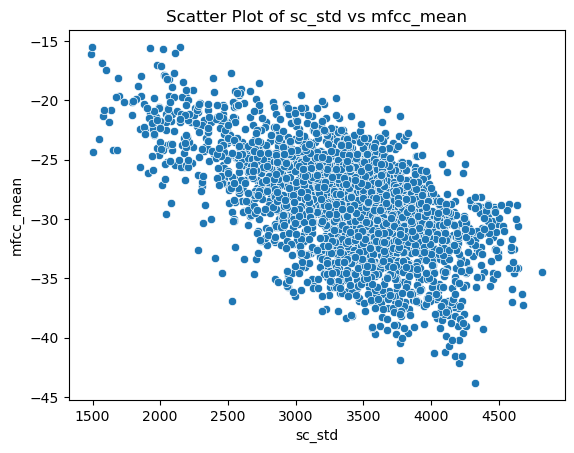

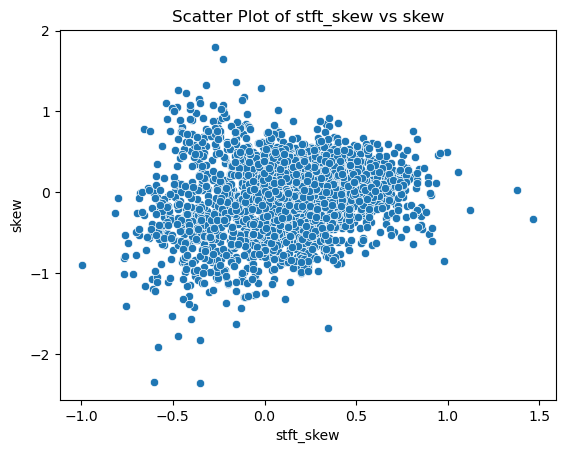

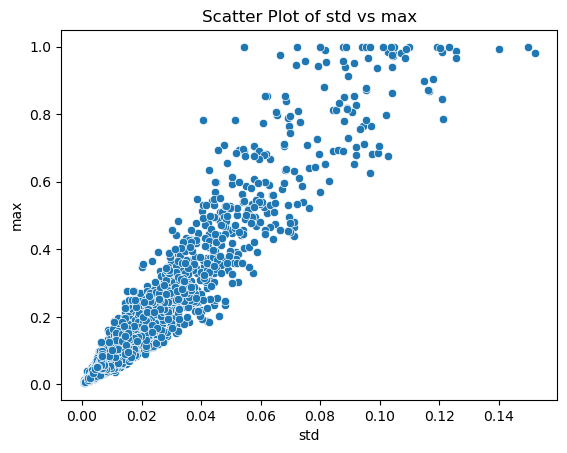

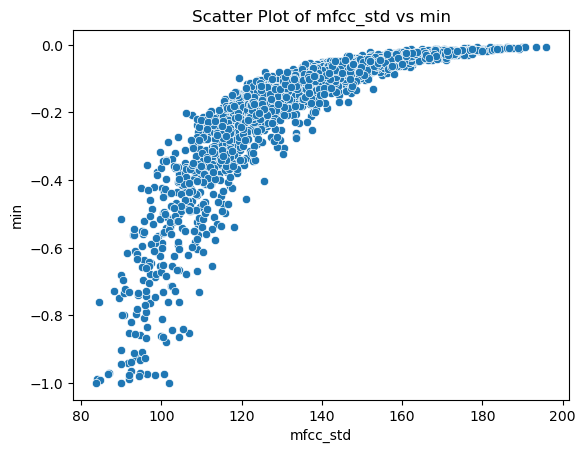

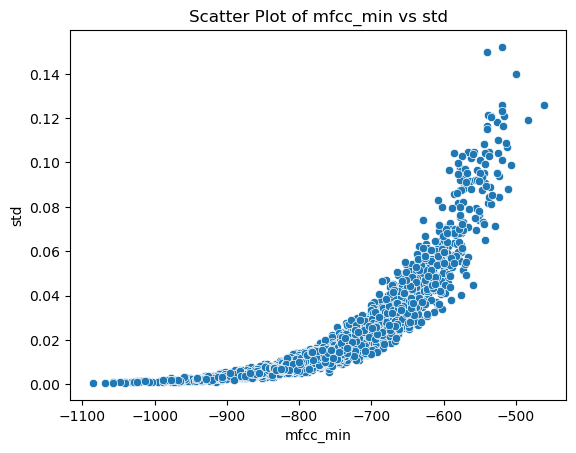

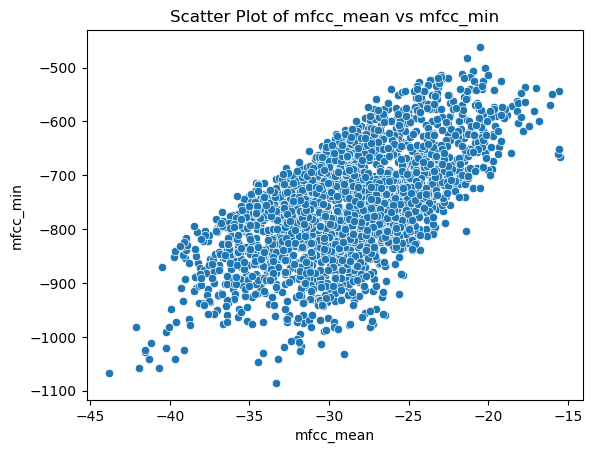

In [49]:
variables = [(df['mfcc_std'], df['std']), 
             (df['sc_std'], df['mfcc_mean']), 
             (df['stft_skew'], df['skew']), 
             (df['std'], df['max']),
             (df['mfcc_std'], df['min']),
             (df['mfcc_min'], df['std']),
             (df['mfcc_mean'], df['mfcc_min'])]
 
for var1, var2 in variables:
    plt.figure()
    sns.scatterplot(x=var1, y=var2)
    plt.xlabel(var1.name)
    plt.ylabel(var2.name)
    plt.title(f"Scatter Plot of {var1.name} vs {var2.name}")
    plt.show()

In questi grafici abbiamo raccolto le coppie di variabili che mostrano i vari tipi di relazione che si osservano nella scatter plot matrix.
In particolare nel caso di stft_skew e skew dallo scatter plot non emerge nessuna correlazione, mentre con mfcc_std e min sembra esserci una correlazione logaritmica.

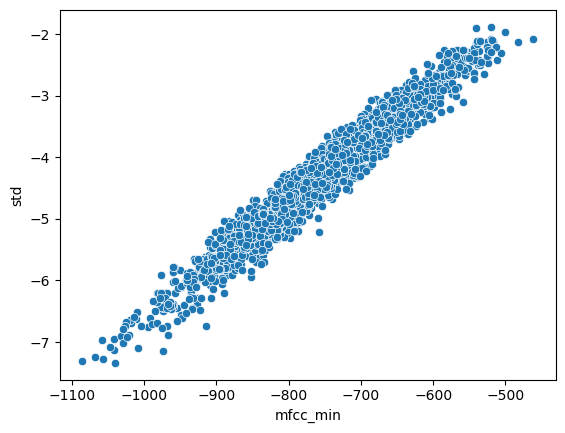

In [96]:
plt.figure()
sns.scatterplot(x=df_copy['mfcc_min'], y=np.log(df['std']))
plt.show()

# Correlazione

In [27]:
#continuous_col_no_nan_const = [col for col in continuous_col if col not in ('intensity', 'stft_max')]

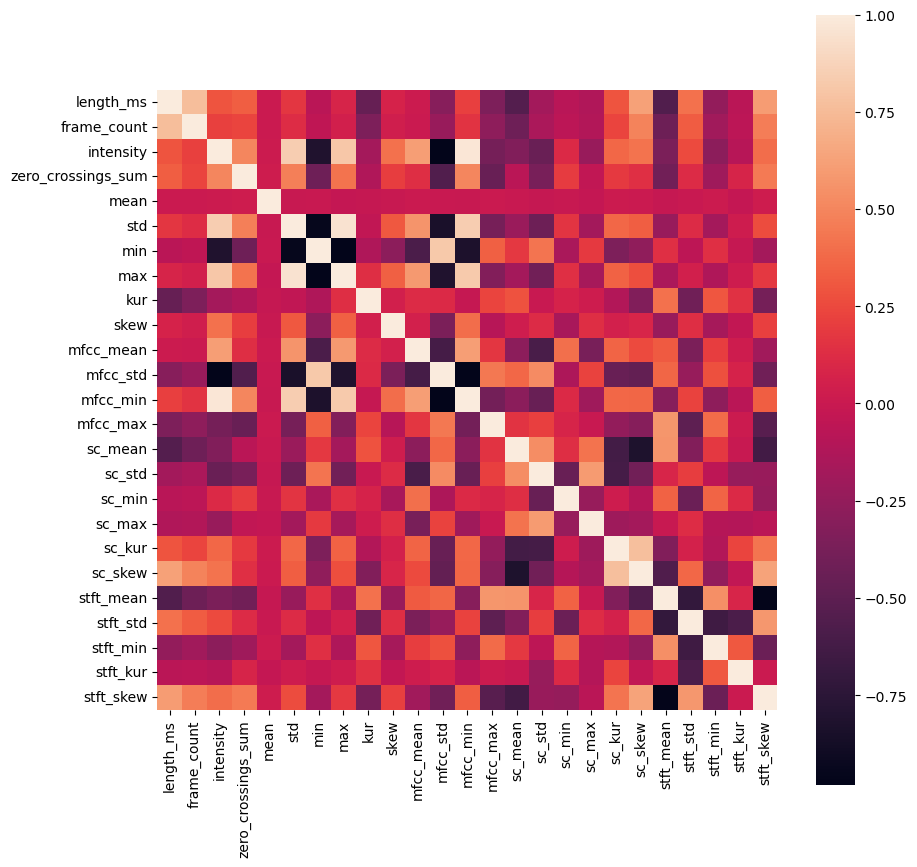

In [34]:
correlation_matrix = df[continuous_col].drop(['stft_max'], axis=1).corr()
plt.figure(figsize = (10,10))
sns.heatmap(correlation_matrix, square=True)
plt.show()

In [35]:
#correlation_series = pd.Series({(row, col): correlation_matrix.loc[row, col] for row in correlation_matrix.index for col in correlation_matrix.columns})
correlation_series = pd.Series({(correlation_matrix.index[i], correlation_matrix.columns[j]): 
                                correlation_matrix.loc[correlation_matrix.index[i], correlation_matrix.columns[j]] 
                                for i in range(len(correlation_matrix)) for j in range(1+i,len(correlation_matrix))})

Serie Pandas che contiene la correlazione di ogni coppia di variabili continue.

In [36]:
max_correlation_series = pd.Series({(row, abs(correlation_matrix[row][correlation_matrix[row]<1]).idxmax()): 
                                    abs(correlation_matrix.loc[row, abs(correlation_matrix[row][correlation_matrix[row]<1]).idxmax()]) 
                                    for row in correlation_matrix.index})

Serie Pandas con solo le coppie più correlate.

In [11]:
correlation_series.sort_values(axis=0, ascending=False, inplace=True, key=abs)

In [37]:
correlation_series[correlation_series.abs() > 0.85]

intensity  mfcc_std    -0.978744
           mfcc_min     0.973981
std        min         -0.955848
           max          0.952821
min        max         -0.979889
mfcc_std   mfcc_min    -0.976098
stft_mean  stft_skew   -0.969979
dtype: float64

Vista l'elevata correlazione andremo a eliminare le variabili intensity (in questo modo rimuoviamo anche il problema dei missing values di intensity), mfcc_min, min, max, stft_mean

In [38]:
max_correlation_series.sort_values(axis=0)

mean                stft_kur       0.027567
skew                intensity      0.411307
sc_min              sc_std         0.447425
kur                 length_ms      0.460723
zero_crossings_sum  mfcc_std       0.559115
mfcc_max            stft_mean      0.572536
stft_kur            stft_std       0.586588
sc_max              sc_std         0.593967
sc_std              sc_kur         0.619887
mfcc_mean           mfcc_std       0.620080
stft_min            stft_std       0.649615
stft_std            stft_mean      0.716319
length_ms           frame_count    0.762874
frame_count         length_ms      0.762874
sc_kur              sc_skew        0.770684
sc_mean             sc_skew        0.823353
sc_skew             sc_mean        0.823353
std                 min            0.955848
stft_mean           stft_skew      0.969979
stft_skew           stft_mean      0.969979
mfcc_min            mfcc_std       0.976098
intensity           mfcc_std       0.978744
mfcc_std            intensity   

Osserviamo che mean ha una correlazione bassissima con tutte le altre variabili.

In [45]:
continuous_col_to_delete = ['frame_count', 'mean', 'stft_max', 'min', 'max', 'stft_mean', 'mfcc_min', 'intensity']
continuous_col_to_keep = [col for col in continuous_col if col not in continuous_col_to_delete]

In [46]:
df_reduced = df[continuous_col_to_keep]
df_reduced['mean'] = df['mean']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_reduced)
df_reduced_scaled = pd.DataFrame(scaled_data, columns=df_reduced.columns)

C:\Users\giang\AppData\Local\Temp\ipykernel_64012\3010368612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['mean'] = df['mean']


In [48]:
df_reduced_scaled.std()

length_ms             0.174082
zero_crossings_sum    0.144122
std                   0.138757
kur                   0.115386
skew                  0.109457
mfcc_mean             0.157544
mfcc_std              0.182082
mfcc_max              0.168929
sc_mean               0.165302
sc_std                0.174400
sc_min                0.239475
sc_max                0.102337
sc_kur                0.105006
sc_skew               0.151127
stft_std              0.130763
stft_min              0.122654
stft_kur              0.085941
stft_skew             0.134467
mean                  0.019699
dtype: float64

Osserviamo che la varianza di mean è significativamente minore rispetto a quella delle altre variabili. In definitiva quindi decidiamo di eliminare la variabile mean.

## Missing Values

In [114]:
null = df.isnull().sum()
perc = (null/(len(df)))*100
perc

modality                0.00
vocal_channel           7.99
emotion                 0.00
emotional_intensity     0.00
statement               0.00
repetition              0.00
actor                  45.92
sex                     0.00
channels                0.00
sample_width            0.00
frame_rate              0.00
frame_width             0.00
length_ms               0.00
frame_count             0.00
intensity              33.28
zero_crossings_sum      0.00
mfcc_mean               0.00
mfcc_std                0.00
mfcc_min                0.00
mfcc_max                0.00
sc_mean                 0.00
sc_std                  0.00
sc_min                  0.00
sc_max                  0.00
sc_kur                  0.00
sc_skew                 0.00
stft_mean               0.00
stft_std                0.00
stft_min                0.00
stft_max                0.00
stft_kur                0.00
stft_skew               0.00
mean                    0.00
std                     0.00
min           

Calcoliamo la percentuale dei valori mancanti. Mentre "vocal_channel" può essere sostituito, la colonna "actor" è difficilmente servibile a causa dell'altissimo numero di valori nulli. 

# Missing Values e Outliers

In [52]:
continuous_col_to_delete = ['frame_count', 'mean', 'stft_max', 'min', 'max', 'stft_mean', 'mfcc_min', 'intensity']
continuous_col_to_keep = [col for col in continuous_col if col not in continuous_col_to_delete]
discrete_col_to_delete = ['modality', 'channels', 'sample_width', 'actor', 'frame_rate', 'frame_width']
discrete_col_to_keep = [col for col in discrete_col if col not in discrete_col_to_delete]

Rimangono da sistemare gli outliers di sc_min e stft_min (che trattiamo come valori errati e quindi missing values) e i missing values di vocal channel.
In praticolare per sc_min e stft_min sfruttiamo la regressione lineare (usando le variabili più correlate rispettivamente con sc_min e stft_min).

Linear Regression su sc_min

<Axes: >

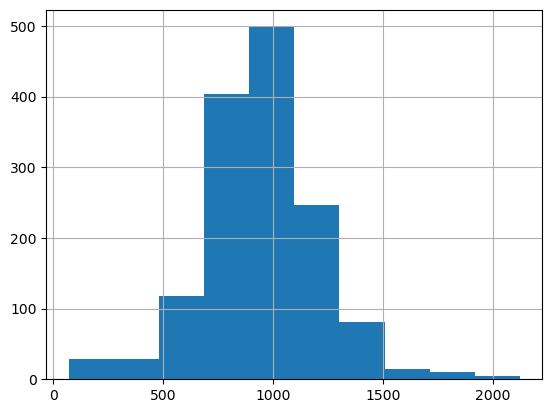

In [86]:
df_copy.loc[df_copy['sc_min'] != 0, 'sc_min'].hist()

In [53]:
df.loc[df['sc_min'] == 0, 'sc_min'] = np.nan

In [55]:
df.loc[df['stft_min'] == 0, 'stft_min'] = np.nan

In [58]:
df[continuous_col].corr()['sc_min'].sort_values(axis=0, key=abs, ascending=False)

sc_min                1.000000
sc_mean               0.380141
mfcc_max             -0.295396
zero_crossings_sum    0.287142
mfcc_mean            -0.283694
sc_skew              -0.163778
sc_max                0.148030
stft_kur              0.147770
length_ms            -0.135113
stft_mean            -0.132376
stft_skew             0.119347
frame_count          -0.105232
max                   0.100646
min                  -0.089992
std                   0.089133
kur                   0.078143
intensity            -0.071734
skew                  0.065122
stft_std             -0.059343
sc_kur               -0.054889
mean                 -0.039063
mfcc_min             -0.026429
stft_min             -0.024736
sc_std               -0.006780
mfcc_std              0.001558
stft_max                   NaN
Name: sc_min, dtype: float64

In [59]:
null_index = np.argwhere(df['sc_min'].isna().values).ravel()
not_nullindex = np.argwhere(~df['sc_min'].isna().values).ravel()

In [60]:
X = df[['sc_mean', 'mfcc_max', 'zero_crossings_sum', 'mfcc_mean', 'sc_skew', 'sc_max']].values
X_train = X[not_nullindex]
y_train = df['sc_min'].values[not_nullindex]
X_test = X[null_index]

In [63]:
reg = LinearRegression()
reg.fit(X_train,y_train)

LinearRegression()

In [64]:
sc_min_pred = reg.predict(X_test)

In [71]:
df.loc[null_index, 'sc_min'] = sc_min_pred

<Axes: >

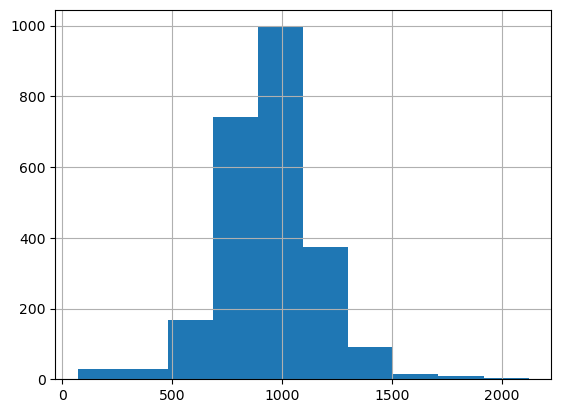

In [88]:
df['sc_min'].hist()

la distribuzione è rimasta abbastanza simile a quella originaria e quindi consideriamo il risultato soddisfacente.

Linear Regression su stft_min

<Axes: >

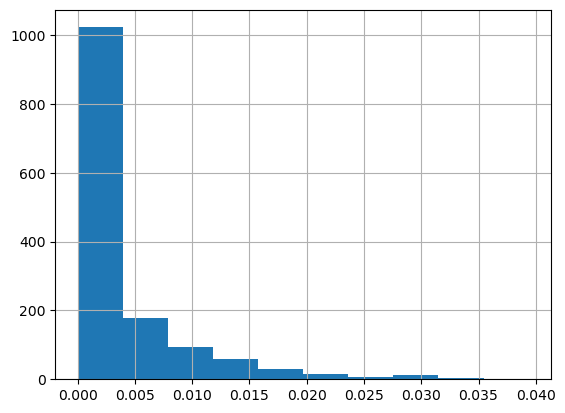

In [85]:
df_copy.loc[df_copy['stft_min'] != 0, 'stft_min'].hist()

In [72]:
df[continuous_col].corr()['stft_min'].sort_values(axis=0, key=abs, ascending=False)

stft_min              1.000000
stft_std             -0.710991
stft_mean             0.597589
stft_skew            -0.482892
intensity            -0.476238
mfcc_std              0.475550
mfcc_min             -0.465746
mfcc_max              0.451222
stft_kur              0.423864
kur                   0.386501
length_ms            -0.341520
zero_crossings_sum   -0.327494
sc_skew              -0.324638
std                  -0.296492
min                   0.250533
frame_count          -0.248188
sc_mean               0.246033
max                  -0.231051
sc_std                0.203673
sc_kur               -0.171086
skew                 -0.120729
sc_max                0.041755
sc_min               -0.024736
mean                  0.013968
mfcc_mean            -0.009270
stft_max                   NaN
Name: stft_min, dtype: float64

In [73]:
null_index2 = np.argwhere(df['stft_min'].isna().values).ravel()
not_nullindex2 = np.argwhere(~df['stft_min'].isna().values).ravel()

In [74]:
X2 = df[['stft_std', 'stft_mean','stft_skew']].values
X_train2 = X2[not_nullindex2]
y_train2 = df['stft_min'].values[not_nullindex2]
X_test2 = X2[null_index2]

In [75]:
reg2 = LinearRegression()
reg2.fit(X_train2,y_train2)

LinearRegression()

In [79]:
stft_min_pred = reg2.predict(X_test2)

In [80]:
df.loc[null_index2, 'stft_min'] = stft_min_pred

<Axes: >

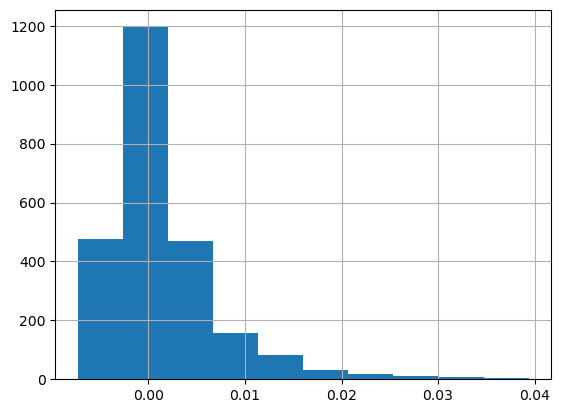

In [84]:
df['stft_min'].hist()

La regressione ha aggiunto qualche valore negativo, ma la distribuzione è rimasta abbastanza simile a quella originaria e quindi consideriamo il risultato soddisfacente.

In ultima istanza si sostituiscono i valori mancanti di vocal_channel con la loro moda. 

In [89]:
df_copy['vocal_channel'].value_counts()/len(df_copy)

vocal_channel
speech    0.544454
song      0.375612
Name: count, dtype: float64

In [81]:
df['vocal_channel'] = df['vocal_channel'].fillna(df['vocal_channel'].mode()[0])

In [90]:
df['vocal_channel'].value_counts()/len(df)

vocal_channel
speech    0.624388
song      0.375612
Name: count, dtype: float64

# Trasformazioni delle variabili

In [97]:
qt = QuantileTransformer(output_distribution='normal')

Quantile tranformer sfrutta la funzione di ripartizione (approssimata) di una variabile per trasformare la variabile in modo che la sua distribuzione diventi normale.

In [98]:
df_norm = df[continuous_col_to_keep]

In [101]:
for column in df_norm.columns:
    df_norm.loc[:, column] = qt.fit_transform(df[[column]])

In [102]:
# Visualize distribution of multiple columns
plt.figure(figsize=(30, 40), dpi=500)
num_columns = len(df_norm.columns)

for i, column in enumerate(df_norm.columns):
    plt.subplot(num_columns, 2, i + 1)
    sns.histplot(df[column], kde=True)
    plt.title(f'Before Transformation - {column}')

    plt.subplot(num_columns, 2, i + num_columns + 1)
    sns.histplot(df_norm[column], kde=True)
    plt.title(f'After Transformation - {column}')

plt.tight_layout()
plt.show()

## Commento finale

Siamo riusciti a preparare i dati per i successivi lavori di clustering e classificazione. Abbiamo creato un file csv appositamente modificato in modo tale da dover apporre solo data preparation apposite per la tipologia di algoritmo che andremo ad utilizzare. 